# SOM, Neural Gas, Multi-Som, Multi-Neural Gas

Elif Cansu YILDIZ   
Salih MARANGOZ

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SOM,-Neural-Gas,-Multi-Som,-Multi-Neural-Gas" data-toc-modified-id="SOM,-Neural-Gas,-Multi-Som,-Multi-Neural-Gas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>SOM, Neural Gas, Multi-Som, Multi-Neural Gas</a></span><ul class="toc-item"><li><span><a href="#Load-Dataset" data-toc-modified-id="Load-Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Dataset</a></span></li><li><span><a href="#Calculate-Neuron-Index-/-Position-Conversion" data-toc-modified-id="Calculate-Neuron-Index-/-Position-Conversion-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Calculate Neuron Index / Position Conversion</a></span></li><li><span><a href="#Trainer-Class-(with-Visualization)" data-toc-modified-id="Trainer-Class-(with-Visualization)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Trainer Class (with Visualization)</a></span></li><li><span><a href="#SOM-Model" data-toc-modified-id="SOM-Model-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>SOM Model</a></span></li><li><span><a href="#Neural-Gas-Model" data-toc-modified-id="Neural-Gas-Model-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Neural Gas Model</a></span></li><li><span><a href="#Multi-Trainer-Class-(with-Visualization)" data-toc-modified-id="Multi-Trainer-Class-(with-Visualization)-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Multi-Trainer Class (with Visualization)</a></span></li><li><span><a href="#Multi-SOM-Model" data-toc-modified-id="Multi-SOM-Model-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Multi-SOM Model</a></span></li><li><span><a href="#Multi-Neural-Gas-Model" data-toc-modified-id="Multi-Neural-Gas-Model-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Multi-Neural Gas Model</a></span></li></ul></li><li><span><a href="#A-program-that-trains-the-M-SOM-(All-in-one)" data-toc-modified-id="A-program-that-trains-the-M-SOM-(All-in-one)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>A program that trains the M-SOM (All-in-one)</a></span></li></ul></div>

**Note:** There is a all-parameters-in-one code block at the end of the notebook which is easy to modify.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation, rc
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128

## Load Dataset

P = 1000  N = 2  M = 0
train_x.shape = (1000, 2)
train_y.shape = (1000, 0)


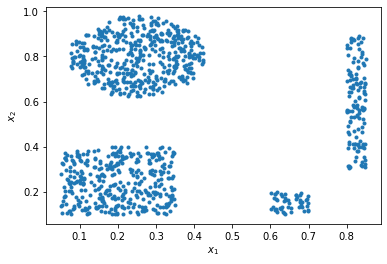

In [2]:
################### PARAMETERS ###################
filename = "data/PA-D-train2.txt"
SEED = 42
np.random.seed(SEED)

################## LOAD DATASET ##################
def loadDataset(filename):
    f = open(filename, "r")
    Lines = f.readlines()

    out = Lines[1].split("=")
    P = int(out[1].split(" ")[0])
    N = int(out[2].split(" ")[0])
    M = int(out[3].split(" ")[0])
    print("P =", P , " N =", N, " M =", M)

    dataset = np.loadtxt(filename)
    x = dataset[:, :N].T
    y = dataset[:, N:].T

    x = x.reshape(N, P)
    y = y.reshape(M, P)

    return x,y,P,N,M

train_x, train_y, P, N, M = loadDataset(filename)

# we will be using row matrices in this notebook
train_x = train_x.T
train_y = train_y.T

print("train_x.shape =", train_x.shape)
print("train_y.shape =", train_y.shape)

_=plt.plot(train_x[:,0], train_x[:,1], ".")
_=plt.xlabel("$x_1$")
_=plt.ylabel("$x_2$")

## Calculate Neuron Index / Position Conversion

In [3]:
def getPosition(idx, shape):
    idx = np.array(idx)
    pos = _getPosition_(idx, shape, [])
    if np.prod(idx.shape) != 1:
        pos = np.array(pos).T
    return pos

def _getPosition_(idx, shape, pos = []):
    idx = np.array(idx)
    shape = np.array(shape)
    shape_left = int(shape[0])
    shape_right = int(np.prod(shape[1:]))
    remaining_idx = idx % shape_right
    cur_idx = idx // shape_right
    pos.append(cur_idx)

    if (len(shape) > 1):
        _getPosition_(remaining_idx, shape[1:], pos)
    return pos

print( "Example for many neurons:\n", getPosition(np.arange(2*2*3), (2,2,3)) )
print( "Example for a single neuron:\n", getPosition(5, (2,2,3)) )

Example for many neurons:
 [[0 0 0]
 [0 0 1]
 [0 0 2]
 [0 1 0]
 [0 1 1]
 [0 1 2]
 [1 0 0]
 [1 0 1]
 [1 0 2]
 [1 1 0]
 [1 1 1]
 [1 1 2]]
Example for a single neuron:
 [0, 1, 2]


## Trainer Class (with Visualization)

In [4]:
class Trainer:
    def __init__(self, model, animate=True, iter_per_frame=10):
        self.model = model
        self.animate = animate
        self.iter_per_frame = iter_per_frame
        self.t = 0

    def train_once(self, x, t):
            response = self.model.calculate_response(x)                  #Calculate the response
            winner = self.model.determine_winner(response)               #Calculate the winner
            change = self.model.learning_rule(x, t, winner)              #Apply the learning rule
            self.model.update(change)                                    #Update

    def train(self, train_x, epoch=1):
        # calculate and set t_max
        t_max = train_x.shape[0]*epoch
        self.model.set_t_max(t_max)
        print("t_max =", t_max)

        ######################################### ANIMATION ##########################################
        if self.animate:
            # Plot static elements
            def init_plot():
                self.plt_train_x, = plt.plot(self.train_x[:,0], self.train_x[:,1], 'k.', alpha=0.1)
                self.plt_center, = plt.plot([], [], 'r*')
                return (self.plt_train_x, self.plt_center,)

            # Train and plot dynamic elements
            def animate_plot(frame_idx):
                # train
                for i in range(self.iter_per_frame):
                    t = i + frame_idx * self.iter_per_frame
                    self.train_once(self.train_x[t % self.train_x.shape[0]], t)

                # visualize
                self.plt_center.set_data(self.model.center[:,0], self.model.center[:,1])
                return (self.plt_train_x, self.plt_center,)
            
            self.train_x = train_x
            self.epoch = epoch
            self.fig, self.ax = plt.subplots()
            anim = animation.FuncAnimation(self.fig, animate_plot, init_func=init_plot,
                                        frames=t_max//self.iter_per_frame, interval=33, 
                                        blit=True)

            # self.animate_plot function runs the train steps
            #return anim.to_jshtml()
            return anim.to_html5_video() 
            
        ######################################### NO ANIMATION ##########################################
        else:
            for e in range(epoch):
                for x in train_x:
                    self.train_once(x, t)
                    t += 1
            return None

## SOM Model

t_max = 3000


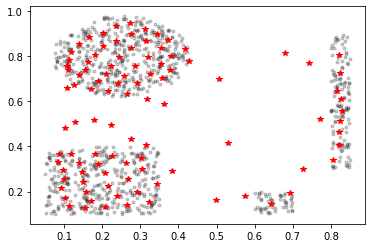

In [5]:
class SOM:   
    """
    N = number of features 
    K = number of neurons
    model_size = shape of the grid (you can adjust the dimension of grid with model_size)"""
    def __init__(self, model_size, N, s_init, s_final, lr_init, lr_final, t_max=0):
        self.model_size = model_size
        self.K = np.prod(model_size)
        ###print("(K,N) = (", self.K,",", N, ")")
        self.center = np.random.uniform(-2.0, 2.0, (self.K, N)) # todo magic value
        self.s_init = s_init   #initial value of size
        self.s_final = s_final #final value of size after t_max steps
        self.t_max = t_max
        self.lr_init = lr_init
        self.lr_final = lr_final

    def set_t_max(self, t_max):
        self.t_max = t_max

    def calculate_response(self, pattern):
        return np.sqrt(np.sum((self.center - pattern)**2, axis=1))

    def determine_winner(self, r_k):
        return np.min(r_k), np.argmin(r_k)

    def learning_rule(self, pattern, t, winner):
        winner_value, winner_idx = winner
        s_t = self.s_init * (self.s_final/self.s_init)**(t/self.t_max)

        winner_neuron_grid_pos = np.array(getPosition(winner_idx, self.model_size))
        ###print("winner_neuron_grid_pos", winner_neuron_grid_pos)

        neighbor_grid_pos = []
        dist = []
        for idx in range(self.K):
            neighbor_grid_pos = np.array(getPosition(idx, self.model_size))
            ###print("neighbor_grid_pos= ", neighbor_grid_pos, " manhattan dist = ", np.sum(np.absolute(winner_neuron_grid_pos - neighbor_grid_pos)))
            dist.append(np.sum(np.absolute(winner_neuron_grid_pos - neighbor_grid_pos)))
            
        ###print("dist=", dist)
        dist = np.array(dist)
        
        h_dist = np.exp(-0.5 * dist**2 / s_t**2)          #neighborhood function
        ###print("h_dist = ", h_dist)
        
        lr_t = self.lr_init * (self.lr_final/self.lr_init)**(t/self.t_max)
        ###print("lr_t = ", lr_t)

        change = None
        for k in range(self.K):   #for each center
            if change is None:
                change = lr_t * h_dist[k] * (pattern - self.center[k])
            else:
                change = np.vstack((change, lr_t * h_dist[k] * (pattern - self.center[k])))
        ###print("change= ", change)

        return change

    def update(self, change):
        ###print("self.center before update=\n", self.center)
        self.center += change
        ###print("self.center after update=\n", self.center)
        return self.center

##################################################################################################

model_size = (10,10)
s_init   = 5.0   #initial value of size
s_final  = 0.5   #final value of size after t_max steps
lr_init  = 0.75
lr_final = 0.05
epoch = 3

model_som = SOM(model_size, N, s_init, s_final, lr_init, lr_final)
trainer_som = Trainer(model_som)
html_som = trainer_som.train(train_x, epoch)
HTML(html_som) # visualize

## Neural Gas Model

t_max = 2000


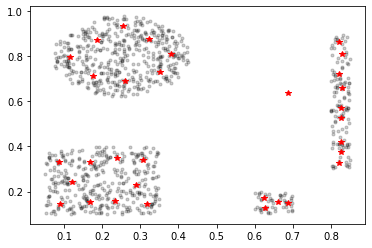

In [6]:
class NeuralGas:   
    """
    N = number of features 
    K = number of neurons"""
    def __init__(self, K, N, s_init, s_final, lr_init, lr_final, t_max=0): 
        self.K = K
        ###print("(K,N) = (", self.K,",", N, ")")
        self.center = np.random.uniform(-1.0, 1.0, (self.K, N))
        self.s_init = s_init   #initial value of size
        self.s_final = s_final #final value of size after t_max steps
        self.t_max = t_max
        self.lr_init = lr_init
        self.lr_final = lr_final
        
    def set_t_max(self, t_max):
        self.t_max = t_max

    def calculate_response(self, pattern):
        self.r_k = np.sqrt(np.sum((self.center - pattern)**2, axis=1))
        return self.r_k

    def determine_winner(self, r_k):
        return np.min(r_k), np.argmin(r_k)

    def learning_rule(self, pattern, t, winner):
        winner_value, winner_idx = winner
        s_t = self.s_init * (self.s_final/self.s_init)**(t/self.t_max)

        sorted_response_list = np.argsort(self.r_k)

        dist = np.zeros((self.K))
        for idx in range(self.K):
            dist[sorted_response_list[idx]] = idx
            
        ###print("dist=", dist)

        h_dist = np.exp(-0.5 * dist**2 / s_t**2)    #neighborhood function
        ###print("h_dist = ", h_dist)
        
        lr_t = self.lr_init * (self.lr_final/self.lr_init)**(t/self.t_max)
        ###print("lr_t = ", lr_t)

        change = None
        for k in range(self.K):   #for each center
            if change is None:
                change = lr_t * h_dist[k] * (pattern - self.center[k])
            else:
                change = np.vstack((change, lr_t * h_dist[k] * (pattern - self.center[k])))
        ###print("change= ", change)

        return change

    def update(self, change):
        ###print("self.center before update=\n", self.center)
        self.center += change
        ###print("self.center after update=\n", self.center)
        return self.center

##################################################################################################

'''
#Without Animation
time = 5
for t in range(time):
    for pattern in train_x[:10]:
        r_k = model.calculate_response(pattern)
        winner_value, winner_idx = model.determine_winner(r_k)
        change = model.learning_rule(pattern, winner_idx, r_k, time=t, lr=0.6)
        model.update(change)
'''

#With Animation
K = 10*10
s_init   = 2.0   #initial value of size
s_final  = 0.1   #final value of size after t_max steps
lr_init  = 0.5
lr_final = 0.01
epoch = 2

model_ng = NeuralGas(K, N, s_init, s_final, lr_init, lr_final)
trainer_ng = Trainer(model_ng)
html_ng = trainer_ng.train(train_x, epoch)
HTML(html_ng) # visualize

## Multi-Trainer Class (with Visualization)

In [7]:
class MultiTrainer:
    def __init__(self, model, animate=True, iter_per_frame=10):
        self.model = model
        self.animate = animate
        self.iter_per_frame = iter_per_frame
        self.t = 0

    def train_once(self, x, t):
        response = self.model.calculate_response(x)                  #Calculate the response
        winner = self.model.determine_winner(response)               #Calculate the winner
        change = self.model.learning_rule(x, t, winner)              #Apply the learning rule
        self.model.update(change)                                    #Update

    def train(self, train_x, epoch=1):
        # calculate and set t_max
        t_max = train_x.shape[0]*epoch
        self.model.set_t_max(t_max)
        print("t_max =", t_max)

        ############################################## ANIMATION PURPOSE #########################################
        if self.animate:

            def init_plot():
                self.plt_train_x, = plt.plot(self.train_x[:,0], self.train_x[:,1], 'k.', alpha=0.1)
                self.plt_center, = plt.plot([], [], 'r*')
                return (self.plt_train_x, self.plt_center,)

            def animate_plot(frame_idx):
                # train
                for i in range(self.iter_per_frame):
                    t = i + frame_idx * self.iter_per_frame
                    self.train_once(self.train_x[t % self.train_x.shape[0]], t)

                # visualize
                x = []
                y = []
                for sm in self.model.submodel:
                    x.append(sm.center[:,0])
                    y.append(sm.center[:,1])
                self.plt_center.set_data(x,y)
                return (self.plt_train_x, self.plt_center,)

            self.train_x = train_x
            self.epoch = epoch
            self.fig, self.ax = plt.subplots()
            anim = animation.FuncAnimation(self.fig, animate_plot, init_func=init_plot,
                                        frames=t_max//self.iter_per_frame, interval=33, 
                                        blit=True)

            # self.animate_plot function runs the train steps
            #return anim.to_jshtml()
            return anim.to_html5_video() 

        ################################################# NO ANIMATION #########################################
        else:           
            for e in range(epoch):
                for x in train_x:
                    self.train_once(x, t)
                    t += 1
            return None

## Multi-SOM Model

t_max = 2000


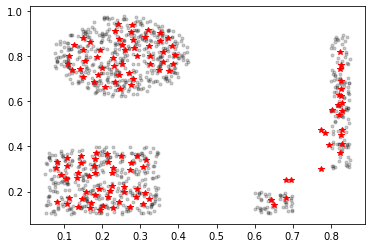

In [8]:
class MultiSOM:
    def __init__(self, M, model_size, N, s_init, s_final, lr_init, lr_final, t_max=0):
        self.M = M
        self.model_size = model_size
        self.submodel = []   #som models
        for i in range(M):
            self.submodel.append( SOM(model_size, N, s_init, s_final, lr_init, lr_final, t_max) )
        self.N = N

    def set_t_max(self, t_max):
        for s in self.submodel:
            s.set_t_max(t_max)

    def calculate_response(self, pattern):
        response = []
        for i in range(M):
            rk = self.submodel[i].calculate_response(pattern)
            response.append(rk)
        return response

    # determine_winner class. return distance and winner som
    def determine_winner(self, response):
        min_distances = []
        min_indexes = []
        for i, r in zip(range(M), response):
            # i -> current som
            # d -> minimum distance of this som
            # idx - > winner neuron of this som
            d, idx = self.submodel[i].determine_winner(r)
            min_distances.append(d)
            min_indexes.append(idx)

        winner_som = np.argmin(min_distances)
        winner_dist = min_distances[winner_som]
        winner_neuron = min_indexes[winner_som]

        return winner_som, winner_dist, winner_neuron

    def learning_rule(self, pattern, t, winner):
        winner_som, winner_dist, winner_neuron = winner
        change = self.submodel[winner_som].learning_rule(pattern, t, (winner_dist, winner_neuron)) # learning_rule for winner som
        return change, winner_som

    def update(self, change):
        change, winner_som = change
        self.submodel[winner_som].update(change)  # update winner for som


##################################################################################################

M = 5
model_size = (5,5)
s_init   = 5.0   #initial value of size
s_final  = 0.5   #final value of size after t_max steps
lr_init  = 0.75
lr_final = 0.05
epoch = 2

model_multi_som = MultiSOM(M, model_size, N, s_init, s_final, lr_init, lr_final)
trainer_multi_som = MultiTrainer(model_multi_som)
html_multi_som = trainer_multi_som.train(train_x, epoch)
HTML(html_multi_som) # visualize

## Multi-Neural Gas Model

t_max = 6000


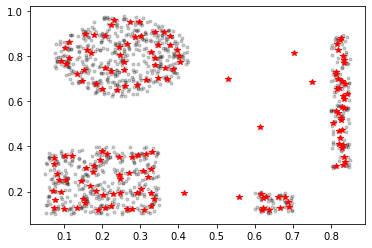

In [9]:
class MultiNeuralGas:
    def __init__(self, M, model_size, N, s_init, s_final, lr_init, lr_final, t_max=0):
        self.M = M
        self.model_size = model_size
        self.submodel = []   #neural gas models
        for i in range(M):
            self.submodel.append( NeuralGas(K, N, s_init, s_final, lr_init, lr_final, t_max) )
        self.N = N

    def set_t_max(self, t_max):
        for s in self.submodel:
            s.set_t_max(t_max)

    def calculate_response(self, pattern):
        response = []
        for i in range(M):
            rk = self.submodel[i].calculate_response(pattern)
            response.append(rk)
        return response

    # determine_winner class. return distance and winner neural_gas
    def determine_winner(self, response):
        min_distances = []
        min_indexes = []
        for i, r in zip(range(M), response):
            # i -> current neural_gas
            # d -> minimum distance of this neural_gas
            # idx - > winner neuron of this neural_gas
            d, idx = self.submodel[i].determine_winner(r)
            min_distances.append(d)
            min_indexes.append(idx)

        winner_neural_gas = np.argmin(min_distances)
        winner_dist = min_distances[winner_neural_gas]
        winner_neuron = min_indexes[winner_neural_gas]

        return winner_neural_gas, winner_dist, winner_neuron

    def learning_rule(self, pattern, t, winner):
        winner_neural_gas, winner_dist, winner_neuron = winner
        change = self.submodel[winner_neural_gas].learning_rule(pattern, t, (winner_dist, winner_neuron)) # learning_rule for winner neural_gas
        return change, winner_neural_gas

    def update(self, change):
        change, winner_neural_gas = change
        self.submodel[winner_neural_gas].update(change)  # update winner for neural_gas


##################################################################################################

M = 4
model_size = (5,5)
s_init   = 5.0   #initial value of size
s_final  = 0.5   #final value of size after t_max steps
lr_init  = 0.75
lr_final = 0.05
epoch = 6

model_multi_neural_gas = MultiNeuralGas(M, model_size, N, s_init, s_final, lr_init, lr_final)
trainer_multi_neural_gas = MultiTrainer(model_multi_neural_gas)
html_multi_neural_gas = trainer_multi_neural_gas.train(train_x, epoch)
HTML(html_multi_neural_gas) # visualize

# A program that trains the M-SOM (All-in-one)

P = 1000  N = 2  M = 0
t_max = 2000


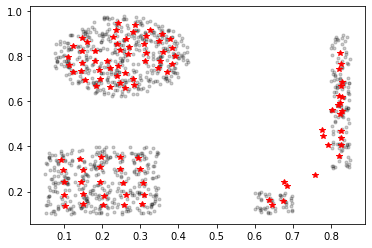

In [10]:
# Parameters
train_file = "data/PA-D-train2.txt"
output_file = "data/PA-D-net.txt"
SEED = 42
np.random.seed(SEED)

# Load dataset
train_x, train_y, P, N, M = loadDataset(train_file)
train_x = train_x.T # we will be using row matrices in this notebook
train_y = train_y.T

# Create M-SOM model
M = 4
model_size = (5,5) # size of each som
s_init   = 4.0     # initial value of size
s_final  = 0.5     # final value of size after t_max steps
lr_init  = 0.60
lr_final = 0.05
epoch = 2

# Train the model
model_multi_som = MultiSOM(M, model_size, N, s_init, s_final, lr_init, lr_final)
trainer_multi_som = MultiTrainer(model_multi_som)
html_multi_som = trainer_multi_som.train(train_x, epoch)

# Output found centers to the file
f = open(output_file, 'w')
try:
    for som in model_multi_som.submodel:
        for c in som.center:
            f.write(str(c[0]) + " " + str(c[1]) + "\n")
finally:
    f.close()

# Visualize
HTML(html_multi_som) 